# Import

In [64]:
import os
import cv2
import glob
import re
import numpy as np
import seaborn as sns
import pandas as pd
import time
import mnist_reader
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from skimage.feature import hog
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif, SelectKBest
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, precision_score, recall_score, f1_score


from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.utils import to_categorical



# Get Images and Labels 

In [65]:
def unify_classes(classes):
    unified_classes = set()
    class_mapping = {}

    for fruit in classes:
        if re.search(r'\s+\d+$', fruit):
            unified_name = re.sub(r'\s+\d+$', '', fruit)
        else:
            unified_name = fruit
        unified_classes.add(unified_name)
        class_mapping[fruit] = unified_name

    return sorted(list(unified_classes)), class_mapping

def getAllFruits(data_path):
    original_classes = []
    for fruit_path in glob.glob(os.path.join(data_path, "*")):
        fruit = fruit_path.split("/")[-1]
        original_classes.append(fruit)
    
    unified_classes, class_mapping = unify_classes(original_classes)
    return unified_classes, class_mapping

def getYourFruits(fruits, class_mapping, data_path, print_n=False):
    images = []
    labels = []
    for i, unified_name in enumerate(fruits):
        original_names = [k for k, v in class_mapping.items() if v == unified_name]
        j = 0
        for fruit_name in original_names:
            folder_pattern = os.path.join(data_path, fruit_name + "*")
            for fruit_folder in glob.glob(folder_pattern):
                for image_path in glob.glob(os.path.join(fruit_folder, "*.jpg")):
                    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                    image = cv2.resize(image, (dim, dim))
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                    images.append(image)
                    labels.append(i)
                    j += 1
        if print_n:
            print(f"There are {j} images for {unified_name.upper()} in {data_path.split('/')[-1].upper()}")
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [66]:
dataset_path = "fruits-360_dataset_100x100/fruits-360"
train_path = os.path.join(dataset_path, "Training")
test_path = os.path.join(dataset_path, "Test")
dim = 100 


fruits, class_mapping = getAllFruits(train_path)
print(f"Number of unified classes: {len(fruits)}")
print(f"Unified Fruits: {fruits}")


X_train, y_train = getYourFruits(fruits, class_mapping, train_path, print_n=False)
print(f"Training data shape: {X_train.shape}, {y_train.shape}")


X_test, y_test = getYourFruits(fruits, class_mapping, test_path, print_n=False)
print(f"Test data shape: {X_test.shape}, {y_test.shape}")




Number of unified classes: 121
Unified Fruits: ['Apple', 'Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red', 'Apple Red Delicious', 'Apple Red Yellow', 'Apple hit', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cabbage white', 'Cactus fruit', 'Cantaloupe', 'Carambula', 'Carrot', 'Cauliflower', 'Cherry', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber', 'Cucumber Ripe', 'Dates', 'Eggplant', 'Eggplant long', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melon Piel de Sapo', 'Mulberry', 'Nectarine', 'Nectarine Flat', 'Nut Forest

In [67]:
#global variables
class_names = fruits
n_components = 400

# 3.1. MLP applied on selected features

### Feature Extraction: HOG and PCA

In [68]:
def extract_hog_features(images, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    hog_features = []
    for image in images:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        features = hog(gray_image, 
                       orientations=orientations, 
                       pixels_per_cell=pixels_per_cell, 
                       cells_per_block=cells_per_block, 
                       block_norm='L2-Hys')
        hog_features.append(features)
    return np.array(hog_features)

In [ ]:
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

X_train_hog[0].reshape(1,-1).shape

In [7]:
pca = PCA(n_components=n_components)

X_train_hog_pca = pca.fit_transform(X_train_hog)
X_test_hog_pca = pca.transform(X_test_hog)

In [8]:
print("X_train_hog:", X_train_hog.shape)
print("X_test_hog:", X_test_hog.shape)
print("X_train_hog_pca:", X_train_hog_pca.shape)
print("X_test_hog_pca:", X_test_hog_pca.shape)

X_train_hog: (70491, 4356)
X_test_hog: (23619, 4356)
X_train_hog_pca: (70491, 400)
X_test_hog_pca: (23619, 400)


### Feature selection

In [ ]:
percentile = 128 / X_train_hog_pca.shape[1] * 100
selector = SelectPercentile(f_classif, percentile=percentile)


X_train_selected = selector.fit_transform(X_train_hog_pca, y_train)
X_test_selected = selector.transform(X_test_hog_pca)

print("X_train_selected:", X_train_selected.shape)
print("X_test_selected:", X_test_selected.shape)


X_train_selected: (70491, 128)
X_test_selected: (23619, 128)


### Data Normalization using StandarScaler

In [11]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_selected)
X_test_normalized = scaler.transform(X_test_selected)

### Validation Set

In [12]:
X_train_small, X_val, y_train_small, y_val = train_test_split(
    X_train_normalized, y_train, test_size=0.2, random_state=42
)

print(f"Training Set Size (0.8): {X_train_small.shape}")
print(f"Validation Set Size (0.2): {X_val.shape}")

print(f"Original Train Set Shape: {X_train_normalized.shape}")
print(f"Test Set Shape: {X_test_normalized.shape}")

Training Set Size (0.8): (56392, 128)
Validation Set Size (0.2): (14099, 128)
Original Train Set Shape: (70491, 128)
Test Set Shape: (23619, 128)


### MLP on selected features

In [13]:
num_classes = len(fruits)

mlp = Sequential([
    Dense(512, input_shape=(X_train_selected.shape[1],)),  # Input shape matches selected features
    Activation('relu'),                                    # ReLU activation
    Dropout(0.3),                                          # Dropout for regularization
    Dense(512),                                            # Hidden layer with 512 units
    Activation('relu'),                                    # ReLU activation
    Dropout(0.3),                                          # Dropout for regularization
    Dense(num_classes),                                    # Output layer with 10 units (num_classes)
    Activation('softmax')                                  # Softmax activation for probabilities
])


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
filepath = "mlp-weights.{epoch:02d}-{val_loss:.2f}.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


### Transforming labels into one-hot encoding format

In [16]:
y_train_small_one_hot = to_categorical(y_train_small, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

print("Shape of y_train_small_one_hot:", y_train_small_one_hot.shape)
print("Shape of y_val_one_hot:", y_val_one_hot.shape)
print("Shape of y_test_one_hot:", y_test_one_hot.shape)

Shape of y_train_small_one_hot: (56392, 121)
Shape of y_val_one_hot: (14099, 121)
Shape of y_test_one_hot: (23619, 121)


### Training the MLP model

In [17]:
start_time = time.time()
history_mlp = mlp.fit(
    X_train_small,                # 80% X_train_normalized
    y_train_small_one_hot,        
    batch_size=128,              
    epochs=25,               
    verbose=1,               
    validation_data=(X_val, y_val_one_hot)  
)
training_time = time.time() - start_time
print(f"Training Time: {training_time:.2f} seconds")


Epoch 1/25
441/441 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5284 - loss: 2.2176 - val_accuracy: 0.9821 - val_loss: 0.0854
Epoch 2/25
441/441 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9531 - loss: 0.1690 - val_accuracy: 0.9952 - val_loss: 0.0262
Epoch 3/25
441/441 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9776 - loss: 0.0812 - val_accuracy: 0.9972 - val_loss: 0.0132
Epoch 4/25
441/441 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9845 - loss: 0.0527 - val_accuracy: 0.9981 - val_loss: 0.0095
Epoch 5/25
441/441 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9884 - loss: 0.0409 - val_accuracy: 0.9980 - val_loss: 0.0076
Epoch 6/25
441/441 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9893 - loss: 0.0350 - val_accuracy: 0.9983 - val_loss: 0.0065
Epoch 7/25
441/441 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9919 - loss: 0.0284 - val_accuracy: 0.9984 - val_loss: 0.0059
Epoch 8/25
441/441 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9904 - loss: 0.0306 - val_accuracy: 0.

In [18]:
best_score = max(history_mlp.history['val_accuracy'])
best_epoch = np.array(history_mlp.history['val_accuracy']).argmax()+1
print('Best test accuracy was %f at epoch %i' % (best_score, best_epoch))

Best test accuracy was 0.999362 at epoch 11


### Table Report

In [19]:
test_loss_mlp, test_accuracy_mlp = mlp.evaluate(X_test_normalized, y_test_one_hot, verbose=1)
print(f"Test Loss: {test_loss_mlp}")
print(f"Test Accuracy: {test_accuracy_mlp}")

739/739 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8745 - loss: 1.0267
Test Loss: 0.9510093927383423
Test Accuracy: 0.8802658915519714


In [20]:

y_pred = mlp.predict(X_test_normalized)

y_pred_classes = y_pred.argmax(axis=1)

y_test_classes = y_test_one_hot.argmax(axis=1)


739/739 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


In [21]:
print(classification_report(y_test_classes, y_pred_classes, digits=4))

              precision    recall  f1-score   support

           0     0.8579    1.0000    0.9235       157
           1     0.7195    0.7195    0.7195       164
           2     0.7277    0.9932    0.8400       148
           3     0.9178    0.8515    0.8834       485
           4     0.9496    0.6890    0.7986       164
           5     0.9497    0.9934    0.9711       152
           6     0.7565    0.7966    0.7761       472
           7     0.9937    0.9458    0.9691       166
           8     0.8715    0.9034    0.8872       383
           9     0.8667    1.0000    0.9286       234
          10     0.9108    0.8720    0.8910       164
          11     0.8071    0.7902    0.7986       143
          12     0.9701    0.9759    0.9730       166
          13     0.9908    0.6506    0.7855       166
          14     0.5838    0.7566    0.6590       152
          15     0.9231    0.5783    0.7111       166
          16     0.7129    0.4800    0.5737       150
          17     0.9107    

### Loss and Accuracy curves

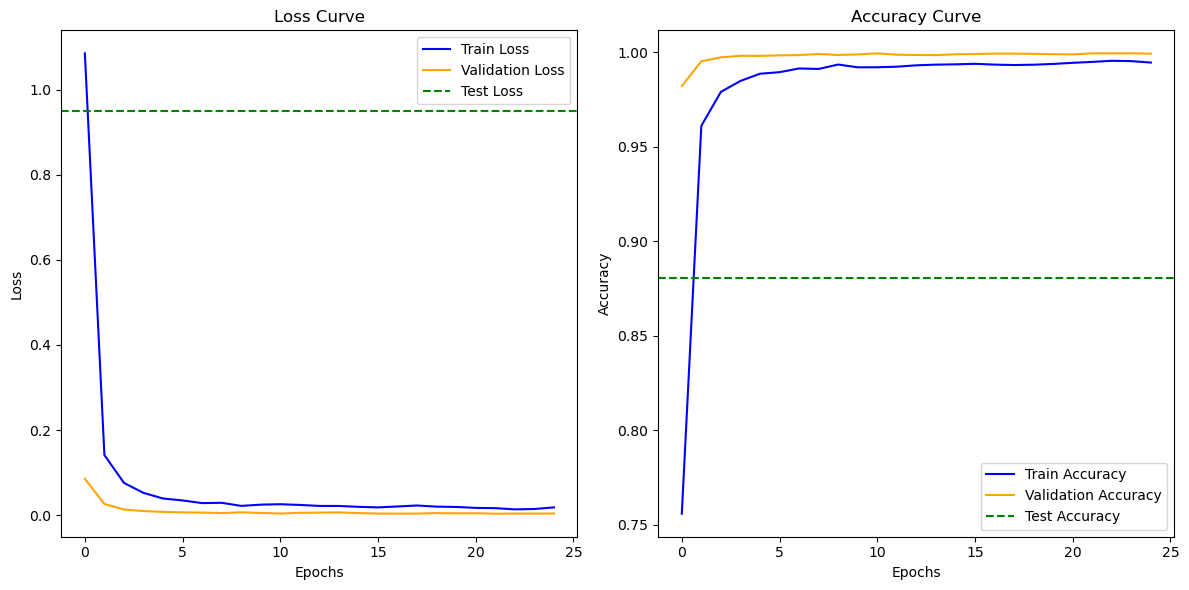

In [22]:
plt.figure(figsize=(12, 6))

#  (loss)
plt.subplot(1, 2, 1)
plt.plot(history_mlp.history['loss'], label='Train Loss', color='blue')
plt.plot(history_mlp.history['val_loss'], label='Validation Loss', color='orange')
plt.axhline(y=test_loss_mlp, color='green', linestyle='--', label='Test Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# (accuracy)
plt.subplot(1, 2, 2)
plt.plot(history_mlp.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history_mlp.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.axhline(y=test_accuracy_mlp, color='green', linestyle='--', label='Test Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 3.2.  MLP applied on images

### Linearization and Normalization

In [23]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)    

scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_flat)
X_test_normalized = scaler.transform(X_test_flat)


### Validation Set

In [24]:
X_train_small, X_val, y_train_small, y_val = train_test_split(
    X_train_normalized, y_train, test_size=0.2, random_state=42
)

print(f"Training Set Size (0.8): {X_train_small.shape}")
print(f"Validation Set Size (0.2): {X_val.shape}")

print(f"Original Train Set Shape: {X_train_normalized.shape}")
print(f"Test Set Shape: {X_test_normalized.shape}")

Training Set Size (0.8): (56392, 30000)
Validation Set Size (0.2): (14099, 30000)
Original Train Set Shape: (70491, 30000)
Test Set Shape: (23619, 30000)


### One_hot conversion

In [25]:
y_train_small_one_hot = to_categorical(y_train_small, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

print("Shape of y_train_small_one_hot:", y_train_small_one_hot.shape)
print("Shape of y_val_one_hot:", y_val_one_hot.shape)
print("Shape of y_test_one_hot:", y_test_one_hot.shape)

Shape of y_train_small_one_hot: (56392, 121)
Shape of y_val_one_hot: (14099, 121)
Shape of y_test_one_hot: (23619, 121)


### MLP on images

In [34]:
mlp_img = Sequential([
    Dense(512, input_shape=(30000,)),  # Input layer with 512 units
    Activation('relu'),             # ReLU activation
    Dropout(0.3),                   # Dropout for regularization
    Dense(512),                     # Hidden layer with 512 units
    Activation('relu'),             # ReLU activation
    Dropout(0.3),                   # Dropout for regularization
    Dense(num_classes),                      # Output layer with 10 units (num_classes)
    Activation('softmax')           # Softmax activation for probabilities
])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
mlp_img.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the MLP on images

In [36]:
start_time = time.time()
history_mlp_img = mlp_img.fit(
    X_train_small,                
    y_train_small_one_hot,        
    batch_size=128,               
    epochs=25,                    
    verbose=1,                   
    validation_data=(X_val, y_val_one_hot)
)
training_time = time.time() - start_time
print(f"Training Time: {training_time:.2f} seconds")


Epoch 1/25
441/441 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.4048 - loss: 4.8551 - val_accuracy: 0.9189 - val_loss: 0.2860
Epoch 2/25
441/441 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.8066 - loss: 0.7329 - val_accuracy: 0.9594 - val_loss: 0.1282
Epoch 3/25
441/441 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.8560 - loss: 0.5700 - val_accuracy: 0.9590 - val_loss: 0.1361
Epoch 4/25
441/441 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.8691 - loss: 0.5807 - val_accuracy: 0.9651 - val_loss: 0.1333
Epoch 5/25
441/441 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.8829 - loss: 0.5818 - val_accuracy: 0.9729 - val_loss: 0.0803
Epoch 6/25
441/441 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.8805 - loss: 0.6840 - val_accuracy: 0.9723 - val_loss: 0.1025
Epoch 7/25
441/441 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.8875 - loss: 0.6727 - val_accuracy: 0.9622 - val_loss: 0.1516
Epoch 8/25
441/441 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.8774 - loss: 0.8207 - 

In [37]:
best_score = max(history_mlp_img.history['val_accuracy'])
best_epoch = np.array(history_mlp_img.history['val_accuracy']).argmax()+1
print('Best test accuracy was %f at epoch %i' % (best_score, best_epoch))

Best test accuracy was 0.980495 at epoch 19


### Table Report

In [38]:
test_loss_mlp_img, test_accuracy_mlp_img = mlp_img.evaluate(X_test_normalized, y_test_one_hot, verbose=1)
print(f"Test Loss: {test_loss_mlp_img}")
print(f"Test Accuracy: {test_accuracy_mlp_img}")

739/739 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8760 - loss: 5.6435
Test Loss: 4.761763095855713
Test Accuracy: 0.8843727707862854


In [39]:
y_pred = mlp_img.predict(X_test_normalized)

y_pred_classes = y_pred.argmax(axis=1)

y_test_classes = y_test_one_hot.argmax(axis=1)


739/739 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step


In [40]:
print(classification_report(y_test_classes, y_pred_classes, digits=4))


              precision    recall  f1-score   support

           0     0.9691    1.0000    0.9843       157
           1     0.5000    0.6646    0.5707       164
           2     0.8933    0.9054    0.8993       148
           3     0.8959    0.9938    0.9423       485
           4     0.9880    1.0000    0.9939       164
           5     0.8686    0.7829    0.8235       152
           6     0.9309    0.7987    0.8597       472
           7     0.9586    0.9759    0.9672       166
           8     0.9895    0.9817    0.9856       383
           9     1.0000    1.0000    1.0000       234
          10     0.9535    1.0000    0.9762       164
          11     0.9408    1.0000    0.9695       143
          12     0.9651    1.0000    0.9822       166
          13     0.1963    0.1928    0.1945       166
          14     0.7857    0.2171    0.3402       152
          15     0.6929    0.5843    0.6340       166
          16     0.5630    0.5067    0.5333       150
          17     1.0000    

### Loss and Accuracy curves

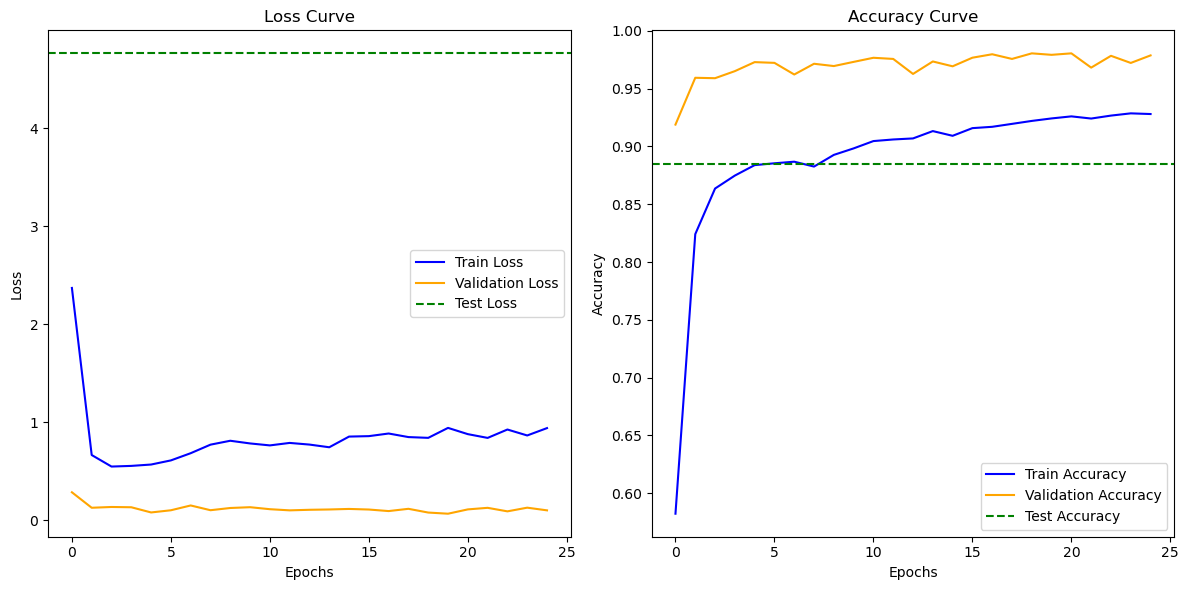

In [41]:
plt.figure(figsize=(12, 6))

#  (loss)
plt.subplot(1, 2, 1)
plt.plot(history_mlp_img.history['loss'], label='Train Loss', color='blue')
plt.plot(history_mlp_img.history['val_loss'], label='Validation Loss', color='orange')
plt.axhline(y=test_loss_mlp_img, color='green', linestyle='--', label='Test Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# (accuracy)
plt.subplot(1, 2, 2)
plt.plot(history_mlp_img.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history_mlp_img.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.axhline(y=test_accuracy_mlp_img, color='green', linestyle='--', label='Test Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 3.3. CNN

### Image normalization [0,1]

In [ ]:
X_train_normalized = X_train / 255.0
X_test_normalized = X_test/ 255.0

In [44]:
print(X_train_normalized.shape)

(70491, 100, 100, 3)


### Validation Set

In [45]:
X_train_small, X_val, y_train_small, y_val = train_test_split(
    X_train_normalized, y_train, test_size=0.2, random_state=42
)

print(f"Training Set Size (0.8): {X_train_small.shape}")
print(f"Validation Set Size (0.2): {X_val.shape}")

print(f"Original Train Set Shape: {X_train_normalized.shape}")
print(f"Test Set Shape: {X_test_normalized.shape}")

Training Set Size (0.8): (56392, 100, 100, 3)
Validation Set Size (0.2): (14099, 100, 100, 3)
Original Train Set Shape: (70491, 100, 100, 3)
Test Set Shape: (23619, 100, 100, 3)


### CNN definition

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout

def create_cnn_model():
    model = Sequential([
        # Layer 1 - Convolutional
        Conv2D(16, (3, 3), padding='same', input_shape=(100, 100, 3)), 
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        # Layer 2 - Convolutional
        Conv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Layer 3 - Convolutional
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        # Flattening
        Flatten(), 

        # Fully Connected Layer
        Dense(128, activation='relu'), 
        Dropout(0.5),

        # Output Layer
        Dense(121, activation='softmax') 
    ])
    return model




## A. CNN on original dataset

In [ ]:
model_without_aug = create_cnn_model()

model_without_aug.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])


start_time = time.time()
history_without_aug = model_without_aug.fit(
    X_train_small, y_train_small,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=128,
    verbose=1
)
training_time = time.time() - start_time
print(f"Training Time: {training_time:.2f} seconds")

Epoch 1/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 85s 190ms/step - accuracy: 0.0716 - loss: 4.2486 - val_accuracy: 0.2982 - val_loss: 2.5766
Epoch 2/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 82s 186ms/step - accuracy: 0.1508 - loss: 3.2609 - val_accuracy: 0.5442 - val_loss: 1.7751
Epoch 3/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 82s 186ms/step - accuracy: 0.1781 - loss: 3.0538 - val_accuracy: 0.5463 - val_loss: 1.7700
Epoch 4/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 81s 184ms/step - accuracy: 0.2008 - loss: 2.9238 - val_accuracy: 0.5202 - val_loss: 1.5885
Epoch 5/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 82s 186ms/step - accuracy: 0.2228 - loss: 2.7873 - val_accuracy: 0.5699 - val_loss: 1.5519
Epoch 6/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 83s 188ms/step - accuracy: 0.2271 - loss: 2.7383 - val_accuracy: 0.7574 - val_loss: 1.1248
Epoch 7/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 85s 193ms/step - accuracy: 0.2422 - loss: 2.6692 - val_accuracy: 0.6247 - val_loss: 1.3176
Epoch 8/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 85s 192ms/step - accuracy: 0.2483 - loss: 2

### Table Report

In [52]:
test_loss_no_aug, test_accuracy_no_aug = model_without_aug.evaluate(
    X_test_normalized, y_test, verbose=0
)

print(f"Test Loss (No Augmentation): {test_loss_no_aug}")
print(f"Test Accuracy (No Augmentation): {test_accuracy_no_aug}")

Test Loss (No Augmentation): 0.8542577028274536
Test Accuracy (No Augmentation): 0.8560057878494263


In [53]:
y_pred = model_without_aug.predict(X_test_normalized)

y_pred_classes = y_pred.argmax(axis=1)

y_test_classes = y_test_one_hot.argmax(axis=1)

739/739 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step


In [54]:
print(classification_report(y_test_classes, y_pred_classes, digits=4))

              precision    recall  f1-score   support

           0     0.7621    1.0000    0.8650       157
           1     0.0000    0.0000    0.0000       164
           2     1.0000    1.0000    1.0000       148
           3     0.7282    1.0000    0.8427       485
           4     1.0000    0.0244    0.0476       164
           5     1.0000    0.6579    0.7937       152
           6     0.6769    0.9809    0.8010       472
           7     0.9792    0.8494    0.9097       166
           8     0.9635    0.9661    0.9648       383
           9     1.0000    0.8504    0.9192       234
          10     0.9647    1.0000    0.9820       164
          11     1.0000    1.0000    1.0000       143
          12     0.9071    1.0000    0.9513       166
          13     0.9006    0.8735    0.8869       166
          14     0.9172    0.8750    0.8956       152
          15     0.9034    0.9578    0.9298       166
          16     0.6635    0.4600    0.5433       150
          17     0.7857    

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## B. CNN on augmented dataset

### Data Augmentation

In [55]:
# definition
data_augmentation = ImageDataGenerator(
    rotation_range=15,            
    width_shift_range=0.1,         
    height_shift_range=0.1,
    horizontal_flip=True,          
    rescale=1.0                    
)

In [56]:
train_generator = data_augmentation.flow(
    X_train_small, y_train_small, batch_size=128
)

### Compile and Train CNN with augmented data

In [57]:

model_with_aug = create_cnn_model()

model_with_aug.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

start_time = time.time()
history_with_aug = model_with_aug.fit(
    train_generator,
    validation_data=(X_val, y_val),
    epochs=20,
    verbose=1
)

training_time = time.time() - start_time
print(f"Training Time: {training_time:.2f} seconds")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - accuracy: 0.0488 - loss: 4.4577 - val_accuracy: 0.1314 - val_loss: 3.4340
Epoch 2/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 80s 181ms/step - accuracy: 0.0881 - loss: 3.7361 - val_accuracy: 0.2250 - val_loss: 2.6199
Epoch 3/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 78s 177ms/step - accuracy: 0.1083 - loss: 3.5495 - val_accuracy: 0.3024 - val_loss: 2.4155
Epoch 4/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 78s 178ms/step - accuracy: 0.1129 - loss: 3.4488 - val_accuracy: 0.3041 - val_loss: 2.2935
Epoch 5/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 78s 176ms/step - accuracy: 0.1195 - loss: 3.3978 - val_accuracy: 0.3569 - val_loss: 2.1410
Epoch 6/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 78s 178ms/step - accuracy: 0.1281 - loss: 3.3354 - val_accuracy: 0.3309 - val_loss: 2.2996
Epoch 7/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 79s 178ms/step - accuracy: 0.1308 - loss: 3.3270 - val_accuracy: 0.4059 - val_loss: 2.0199
Epoch 8/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 78s 177ms/step - accuracy: 0.1398 - loss: 3

### Table Report

In [58]:
test_loss_with_aug, test_accuracy_with_aug = model_with_aug.evaluate(
    X_test_normalized, y_test, verbose=0
)

print(f"Test Loss (No Augmentation): {test_loss_no_aug}")
print(f"Test Accuracy (No Augmentation): {test_accuracy_no_aug}")

Test Loss (No Augmentation): 0.8542577028274536
Test Accuracy (No Augmentation): 0.8560057878494263


In [59]:

y_pred = model_with_aug.predict(X_test_normalized)

y_pred_classes = y_pred.argmax(axis=1)

y_test_classes = y_test_one_hot.argmax(axis=1)


739/739 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step


In [60]:
print(classification_report(y_test_classes, y_pred_classes, digits=4))


              precision    recall  f1-score   support

           0     0.9551    0.9490    0.9521       157
           1     0.1038    0.0671    0.0815       164
           2     0.9500    0.6419    0.7661       148
           3     0.9778    1.0000    0.9888       485
           4     1.0000    1.0000    1.0000       164
           5     0.7273    0.4737    0.5737       152
           6     0.6448    1.0000    0.7841       472
           7     1.0000    0.1386    0.2434       166
           8     0.8988    0.7650    0.8265       383
           9     0.9070    1.0000    0.9512       234
          10     0.9371    1.0000    0.9676       164
          11     0.9795    1.0000    0.9896       143
          12     0.0000    0.0000    0.0000       166
          13     1.0000    0.7831    0.8784       166
          14     0.9466    0.8158    0.8763       152
          15     1.0000    0.5964    0.7472       166
          16     0.5946    0.4400    0.5057       150
          17     0.0000    

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Loss and Accuracy curves for the CNN (with and without Data Augmentation)

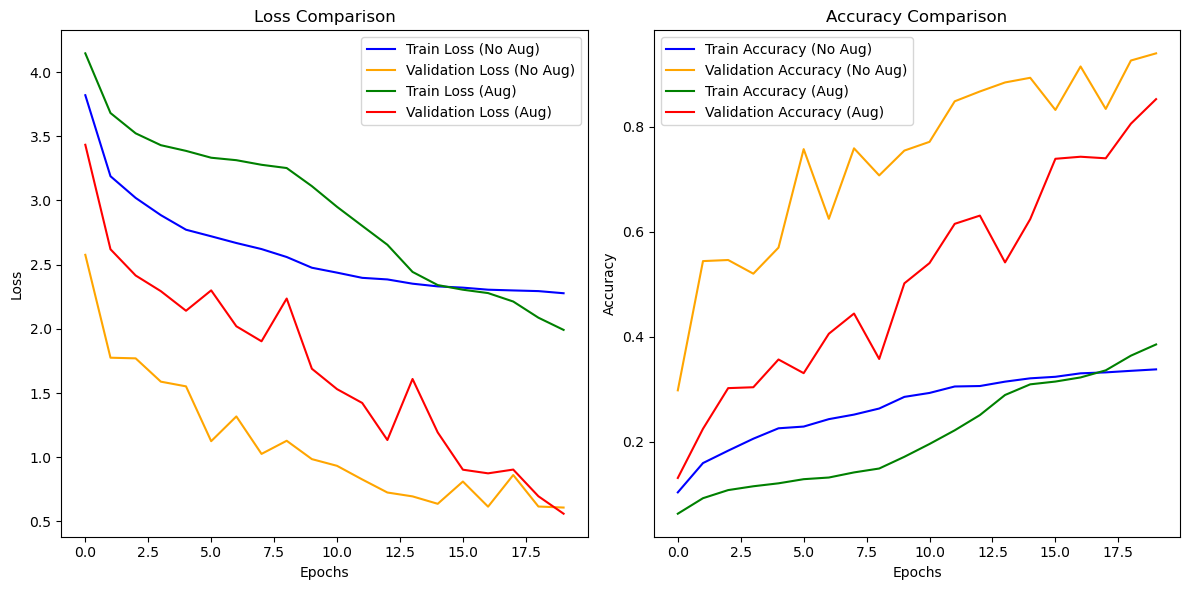

In [ ]:

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_without_aug.history['loss'], label='Train Loss (No Aug)', color='blue')
plt.plot(history_without_aug.history['val_loss'], label='Validation Loss (No Aug)', color='orange')
plt.plot(history_with_aug.history['loss'], label='Train Loss (Aug)', color='green')
plt.plot(history_with_aug.history['val_loss'], label='Validation Loss (Aug)', color='red')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_without_aug.history['accuracy'], label='Train Accuracy (No Aug)', color='blue')
plt.plot(history_without_aug.history['val_accuracy'], label='Validation Accuracy (No Aug)', color='orange')
plt.plot(history_with_aug.history['accuracy'], label='Train Accuracy (Aug)', color='green')
plt.plot(history_with_aug.history['val_accuracy'], label='Validation Accuracy (Aug)', color='red')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# 3.4 Finetuning over ResNet-18 Architecture

### Preprocess the dataset

In [70]:
import torch
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.Grayscale(3),     
    transforms.ToTensor(),       
    transforms.Normalize((0.5,), (0.5,))  
])


X_train_transformed = torch.stack([transform(img) for img in X_train])
X_test_transformed = torch.stack([transform(img) for img in X_test])


### Convert Labels to Tensor

In [71]:
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


### Split into train, validation, and test sets

In [72]:
X_train_small, X_val, y_train_small, y_val = train_test_split(
    X_train_transformed, y_train_tensor, test_size=0.2, random_state=42
)

print(f"Training Set Size: {X_train_small.shape}")
print(f"Validation Set Size: {X_val.shape}")

Training Set Size: torch.Size([56392, 3, 32, 32])
Validation Set Size: torch.Size([14099, 3, 32, 32])


### Create DataLoader

In [73]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_small, y_train_small)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test_transformed, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

### Load Pretrained ResNet-18

In [74]:
from torchvision.models import resnet18
from torch import nn

model = resnet18(pretrained=True)


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [75]:
model.fc = nn.Linear(model.fc.in_features, num_classes)


### Define Optimizer and Loss

In [76]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()


In [77]:
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
model = model.to(device)
print(f"Using device: {device}")
print(torch.backends.mps.is_available()) # true


Using device: mps
True


### Train the model

In [78]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

start_time = time.time()

for epoch in range(25):
    # train
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # validate
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    scheduler.step()

end_time = time.time()
training_time = end_time - start_time
print(f"Total Training Time: {training_time:.2f} seconds")


Epoch 1, Train Loss: 0.4223, Train Acc: 0.9085, Val Loss: 0.0067, Val Acc: 0.9991
Epoch 2, Train Loss: 0.0050, Train Acc: 0.9996, Val Loss: 0.0019, Val Acc: 0.9999
Epoch 3, Train Loss: 0.0022, Train Acc: 0.9999, Val Loss: 0.0011, Val Acc: 0.9999
Epoch 4, Train Loss: 0.0014, Train Acc: 1.0000, Val Loss: 0.0009, Val Acc: 0.9999
Epoch 5, Train Loss: 0.0010, Train Acc: 1.0000, Val Loss: 0.0008, Val Acc: 0.9999
Epoch 6, Train Loss: 0.0008, Train Acc: 1.0000, Val Loss: 0.0007, Val Acc: 0.9999
Epoch 7, Train Loss: 0.0007, Train Acc: 1.0000, Val Loss: 0.0006, Val Acc: 0.9999
Epoch 8, Train Loss: 0.0006, Train Acc: 1.0000, Val Loss: 0.0006, Val Acc: 0.9999
Epoch 9, Train Loss: 0.0006, Train Acc: 1.0000, Val Loss: 0.0006, Val Acc: 0.9999
Epoch 10, Train Loss: 0.0006, Train Acc: 1.0000, Val Loss: 0.0006, Val Acc: 0.9999
Epoch 11, Train Loss: 0.0006, Train Acc: 1.0000, Val Loss: 0.0006, Val Acc: 0.9999
Epoch 12, Train Loss: 0.0006, Train Acc: 1.0000, Val Loss: 0.0006, Val Acc: 0.9999
Epoch 13, Tra

### Evaluate the model on the test set

In [79]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = correct / total

    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    return precision, recall, f1

precision, recall, f1 = evaluate_model(model, test_loader, device)

Test Accuracy: 0.9461
Precision: 0.9507, Recall: 0.9461, F1-Score: 0.9451


### Loss and Accuracy Curves

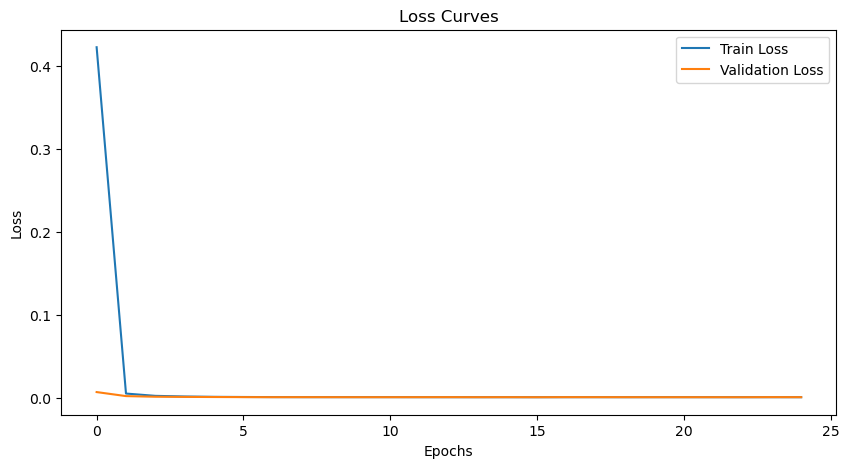

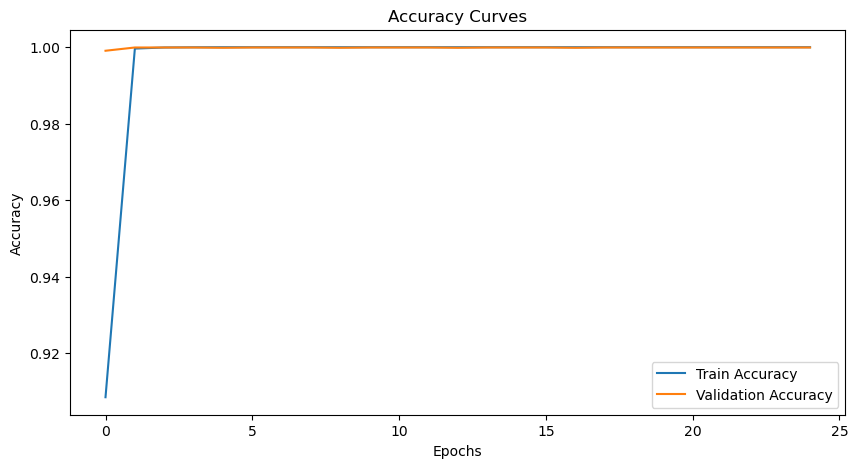

In [80]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.show()